In [2]:
from __future__ import print_function, absolute_import
from WISE_tools import *
import FATS, pandas as pd, numpy as np
from multiprocessing import Pool
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import fitting
from scipy.odr import *
from sklearn.metrics import r2_score

In [3]:
unique_names = parse_source_names('../data/bright_blue_lightcurves/data/')

In [282]:
def KDE_fit(x,y):
    """
    A function that performs a gaussian KDE on x/y data, then fits the result with a sum
    of 2 2D gaussians
    
    Parameters
    ----------
    x : array-like
        x data
    y : array-like
        y data
        
    Returns
    -------
    KDE_bandwidth : float
        Cross-validated kernel bandwidth
    KD_fit_sqresid : float
        The mean squared residual (fit - KDE)^2
    amp_0 : float
        amplitude of largest gaussian
    xmean_0 : float
        x mean of largest gaussian
    ymean_0 : float
        y mean of largest gaussian
    major_std_0 : float
        Standard deviation along major axis of largest gaussian
    theta_0 : float
        Radians between positive X-axis and the major axis of the largest gaussian
    ecc_0 : float
        Eccentricity of an ellipse, taken at an arbitrary height of the largest gaussian
    amp_1 : float
        amplitude of smallest gaussian
    xmean_1 : float
        x mean of smallest gaussian
    ymean_1 : float
        y mean of smallest gaussian
    major_std_1 : float
        Standard deviation along major axis of smallest gaussian
    theta_1 : float
        Radians between positive X-axis and the major axis of the largest gaussian
    ecc_1 : float
        Eccentricity of an ellipse, taken at an arbitrary height of the smallest gaussian
    """
    
    data = np.vstack([x, y]).T
    #Grid search for best KDE bandwidth
    params = {'bandwidth': np.linspace(np.min(np.diff(y)),np.max(np.diff(y)),100)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)
    
    KDE_bandwidth = grid.best_estimator_.bandwidth
    
    kde = grid.best_estimator_
    X, Y = np.meshgrid(np.linspace(np.min(x),np.max(x),100), np.linspace(np.min(y),np.max(y),100))

    xy = np.vstack([X.ravel(), Y.ravel()]).T
    #compute the KDE on a 100x100 grid of points
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
    
    #fit KDE estimation with 2 Gaussian model
    g2D_init1 = Gaussian2D(amplitude=np.max(Z), x_mean=X[np.unravel_index(np.argmax(Z),Z.shape)], y_mean=Y[np.unravel_index(np.argmax(Z),Z.shape)], x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})
    g2D_init2 = Gaussian2D(amplitude=np.median(Z), x_mean=np.median(x), y_mean=np.median(y), x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})
    g2D_init = g2D_init1 + g2D_init2

    fitter = fitting.LevMarLSQFitter()
    
    g2D = fitter(g2D_init, X, Y, Z)
    
    KD_fit_sqresid = np.mean(np.power(Z-g2D(X,Y),2.0))
    
    #Sort by largest and smallest amplitude gaussian
    i_large = np.argmax([g2D.amplitude_0,g2D.amplitude_1])
    i_small = np.argmin([g2D.amplitude_0,g2D.amplitude_1])
    g2D_large = g2D[i_large]
    g2D_small = g2D[i_small]
    
    amp_0 = g2D_large.amplitude.value
    amp_1 = g2D_small.amplitude.value
    
    xmean_0 = g2D_large.x_mean.value
    xmean_1 = g2D_small.x_mean.value
    
    ymean_0 = g2D_large.y_mean.value
    ymean_1 = g2D_small.y_mean.value
    
    if g2D_large.x_stddev >= g2D_large.y_stddev:
        
        major_std_0 = g2D_large.x_stddev.value
        theta_0 = g2D_large.theta.value
        ecc_0 = np.sqrt(1.0 - (g2D_large.y_stddev.value/g2D_large.x_stddev.value)**2.0)
    
    else:
        
        major_std_0 = g2D_large.y_stddev.value
        
        if g2D_large.theta <= np.pi/2:
            theta_0 = np.pi/2 + g2D_large.theta.value
            
        elif g2D_large.theta > np.pi/2:
            theta_0 = g2D_large.theta.value - np.pi/2
             
        ecc_0 = np.sqrt(1.0 - (g2D_large.x_stddev.value/g2D_large.y_stddev.value)**2.0)
        
    if g2D_small.x_stddev >= g2D_small.y_stddev:
        
        major_std_1 = g2D_small.x_stddev.value
        theta_1 = g2D_small.theta.value
        ecc_1 = np.sqrt(1.0 - (g2D_small.y_stddev.value/g2D_small.x_stddev.value)**2.0)
    
    else:
        
        major_std_1 = g2D_small.y_stddev.value
        
        if g2D_small.theta <= np.pi/2:
            theta_1 = np.pi/2 + g2D_small.theta.value
            
        elif g2D_small.theta > np.pi/2:
            theta_1 = g2D_small.theta.value - np.pi/2
             
        ecc_1 = np.sqrt(1.0 - (g2D_small.x_stddev.value/g2D_small.y_stddev.value)**2.0)
        
    return (KDE_bandwidth, KD_fit_sqresid, amp_0, xmean_0, ymean_0, major_std_0, theta_0,
            ecc_0, amp_1, xmean_1, ymean_1, major_std_1, theta_1, ecc_1)

In [291]:
def line(p, x):
    m, b = p
    return m*x + b

In [313]:
def linear_CMD_fit(x,y,xerr,yerr):
    """
    Does a linear fit to CMD data where x is color and y is amplitude, returning some fit 
    statistics
    
    Parameters
    ----------
    x : array-like
        color
    y : array-like
        magnitude
    xerr : array-like
        color errors
    yerr : array-like
        magnitude errors
    
    Returns
    -------
    slope : float
        slope of best-fit line
    r_squared : float
        Correlation coefficient (R^2)
    """
    
    data = RealData(x, y, sx=xerr, sy=yerr)
    
    mod = Model(line)
    
    odr = ODR(data, mod, beta0=[-0.1, np.mean(y)])
    out = odr.run()
    
    slope = out.beta[0]
    
    r_squared = r2_score(y, line(out.beta, x))
    
    return slope, r_squared

(10.1, 9.0)

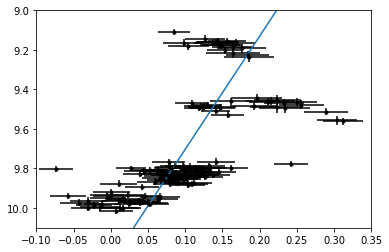

In [312]:
x = df['w1mpro'].values - df['w2mpro'].values
xerr = np.sqrt(df['w1sigmpro'].values*df['w1sigmpro'].values + df['w2sigmpro'].values*df['w2sigmpro'].values)

y = df['w1mpro'].values
yerr = df['w1sigmpro'].values
s,r,b = linear_CMD_fit(x, y, xerr, yerr)
plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
xtest = np.linspace(np.min(x),np.max(x),100)
plt.plot(xtest,line(b,xtest))
plt.xlim(-0.1,0.35)
plt.ylim(10.1,9.0)

In [5]:
def get_features(name):
    """
    A function that is given a name, and then outputs all 68 features (plus the name)
    in a handy pandas dataframe.
    
    Parameter
    ---------
    Name : str
        WISE source name output by WISE_tools.parse_source_names
        
    Returns
    -------
    features : `~pandas.DataFrame`
        Dataframe of all 68 features, plus a column for the name.
    """
    
    df = get_lightcurve(name, 'test_data/')
    lc = np.array([df['w1mpro'].values,df['mjd'].values,df['w1sigmpro'].values,
                df['w2mpro'].values,df['w1mpro'].values,df['w2mpro'].values,
                df['mjd'].values,df['w1sigmpro'].values,df['w2sigmpro'].values])
    
    a = FATS.FeatureSpace(Data=['magnitude', 'time', 'error', 'magnitude2', 'error2'],
                           excludeList=[])
    a.calculateFeature(lc)
    result = a.result('dict')
    
    #Now let's add our own features
    #KDE in CMD space
    x = df['w1mpro'].values - df['w2mpro'].values
    xerr = np.sqrt(df['w1sigmpro'].values*df['w1sigmpro'].values + df['w2sigmpro'].values*df['w2sigmpro'].values)
    
    y = df['w1mpro'].values
    yerr = df['w1sigmpro'].values
    
    (KDE_bandwidth, KD_fit_sqresid, amp_0, xmean_0, ymean_0, major_std_0, theta_0,
            ecc_0, amp_1, xmean_1, ymean_1, major_std_1, theta_1, ecc_1) = KDE_fit(x,y)
    
    result['KDE_bandwidth'] = KDE_bandwidth
    result['KD_fit_sqresid'] = KD_fit_sqresid
    result['KD_amp_0'] = amp_0
    result['KD_xmean_0'] = xmean_0
    result['KD_ymean_0'] = ymean_0
    result['KD_major_std_0'] = major_std_0
    result['KD_theta_0'] = theta_0
    result['KD_ecc_0'] = ecc_0
    result['KD_amp_1'] = amp_1
    result['KD_xmean_1'] = xmean_1
    result['KD_ymean_1'] = ymean_1
    result['KD_major_std_1'] = major_std_1
    result['KD_theta_1'] = theta_1
    result['KD_ecc_1'] = ecc_1
    
    slope, r_squared = linear_CMD_fit(x, y, xerr, yerr)
    result['CMD_slope'] = slope
    result['CMD_r_squared'] = r_squared
    
    result['Name'] = name
    
    return pd.DataFrame(data=np.array(result.values()).reshape(1,len(result.values())), 
                        columns=result.keys())

In [300]:
%%time
p = Pool(8)
dfs = p.map(get_features,np.tile(unique_names,8))
out = pd.concat(dfs)
out.to_csv('test_features.csv')

/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/carina/anaconda/envs/iraf27/lib/python2.7/site-packages/scipy/optimize/_minimize.py

CPU times: user 492 ms, sys: 305 ms, total: 797 ms
Wall time: 2min 2s


In [280]:

x = df['w1mpro'] - df['w2mpro']
y = df['w1mpro']
data = np.vstack([x, y]).T

params = {'bandwidth': np.linspace(np.min(np.diff(y)),np.max(np.diff(y)),100)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

best bandwidth: 0.117666666667


In [283]:
KDE_fit(x,y)

(0.11766666666666586,
 0.017015238037743675,
 5.350432457159215,
 0.051610126532854884,
 9.8750001749091609,
 0.12883185479475004,
 1.9181802311090403,
 0.4830059039543031,
 1.7139867169706167,
 0.16978269627539769,
 9.4605874745791443,
 0.45076088054479002,
 1.5707963267948966,
 0.959084483324255)

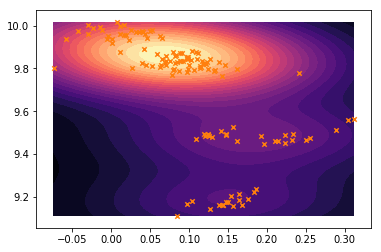

In [252]:
X, Y = np.meshgrid(np.linspace(np.min(x),np.max(x),100), np.linspace(np.min(y),np.max(y),100))

xy = np.vstack([X.ravel(), Y.ravel()]).T

Z = np.exp(kde.score_samples(xy)).reshape(X.shape)

levels = np.linspace(0, Z.max(), 25)
plt.contourf(X, Y, Z, levels=levels, cmap='magma')
plt.scatter(x,y,marker='x',c='C1',s=20)
plt.savefig('kde_test.png')

In [288]:


g2D_init1 = Gaussian2D(amplitude=np.max(Z), x_mean=X[np.unravel_index(np.argmax(Z),Z.shape)], y_mean=Y[np.unravel_index(np.argmax(Z),Z.shape)], x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})
g2D_init2 = Gaussian2D(amplitude=np.median(Z), x_mean=np.median(x), y_mean=np.median(y), x_stddev=np.std(x), y_stddev=np.std(y), theta=0, bounds={'theta': (0,np.pi),'x_mean': (np.min(x),np.max(x)),'y_mean': (np.min(y),np.max(y)),'x_stddev':(0.001,1),'y_stddev':(0.001,1)})

g2D_init = g2D_init1 + g2D_init2

fitter = fitting.LevMarLSQFitter()

g2D = fitter(g2D_init, X, Y, Z)
print(g2D)

Model: CompoundModel9
Inputs: (u'x', u'y')
Outputs: (u'z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian2D(amplitude=6.074548864171432, x_mean=0.0741616161616167, y_mean=9.86059595959596, x_stddev=0.07246902839754349, y_stddev=0.26312666108954447, theta=0.0)>

    [1]: <Gaussian2D(amplitude=1.5187277115571889, x_mean=0.0990000000000002, y_mean=9.816, x_stddev=0.07246902839754349, y_stddev=0.26312666108954447, theta=0.0)>
Parameters:
     amplitude_0      x_mean_0       y_mean_0   ...   y_stddev_1   theta_1
    ------------- --------------- ------------- ... -------------- -------
    5.35043245716 0.0516101265329 9.87500017491 ... 0.450760880545     0.0


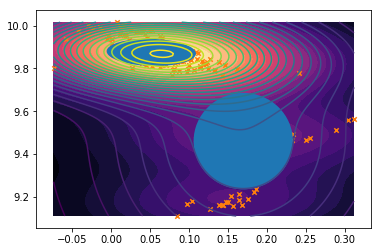

In [289]:
fig,ax = plt.subplots()
ax.contourf(X, Y, Z, levels=levels, cmap='magma')
foo = g2D[0]
bar = g2D[1]
ax.add_artist(Ellipse((foo.parameters[1],foo.parameters[2]), foo.parameters[4], foo.parameters[3], angle=np.degrees(1.9181802311090403)))
ax.add_artist(Ellipse((bar.parameters[1],bar.parameters[2]), bar.parameters[4], bar.parameters[3], angle=np.degrees(1.5707963267948966)))
ax.contour(X, Y, g2D(X,Y), levels=levels, cmap='viridis')
ax.scatter(x,y,marker='x',c='C1',s=20)

plt.savefig('kde_fit.png')

0.017822298124535191

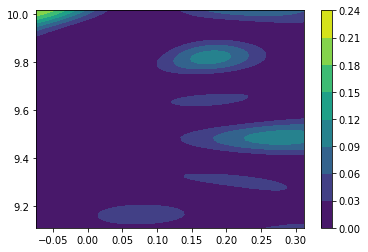

In [260]:
plt.contourf(X,Y,np.power(Z-g2D(X,Y),2.0))
plt.colorbar()
np.mean(np.power(Z-g2D(X,Y),2.0))

In [276]:
foo = g2D[1]
foo.parameters

array([  1.72413511e+00,   1.68366354e-01,   9.47957886e+00,
         1.27757536e-01,   4.71413646e-01,   4.90446000e-03])

In [13]:
from matplotlib.patches import Ellipse

In [14]:
%%time
lens = []
for name in unique_names:
    df = get_lightcurve(name,'../data/bright_blue_lightcurves/data/')
    lens.append(len(df))

CPU times: user 2min 51s, sys: 21.3 s, total: 3min 13s
Wall time: 3min 20s


(0, 500)

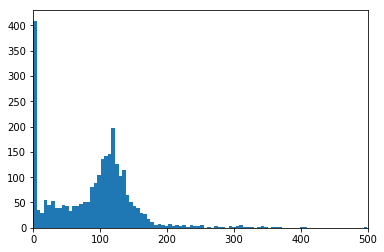

In [12]:
plt.hist(lens,bins=500);
plt.xlim(0,500)

In [19]:
foo = np.array(lens)
len(foo[foo >= 25])

2149

In [20]:
len(foo)

2698